## CNN Evaluation

## 1. Preprocessing
### 1.1 Imports

In [1]:
import os
# Ignore warning from tensorflow since the deprecation warning does not concern us
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras_tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

### 1.2 Loading of preprocessed data

In [4]:
# Load ground truth
Ytrain = np.load('3rdISICTrainGT_preprocessed.npy')
Ytest = np.load('3rdISICTestGT_preprocessed.npy')

# Load data
Xtrain = np.load('3rdISICTrainpics_preprocessed.npy')
Xtest = np.load('3rdISICTestpics_preprocessed.npy')

### 1.3 Addtional necessary preprocessing for CNN

Subtract 1 from the label arrays so that the possible label values start at 0. This is necessary for the to_categorial() method

In [5]:
Ytrain=Ytrain-1
Ytest=Ytest-1

Convert the class labels in Ytrain and Ytest into one-hot encoded format. One-hot encoding is a representation of categorical variables as binary vectors, where each index corresponds to a class and the corresponding entry is set to 1 to represent the class of the instance. 

For example: [3] -> [0,0,0,1,0,0,0]

In [6]:
num_classes = 7
print(Ytrain.shape)
Ytrain = to_categorical(Ytrain, num_classes=num_classes)
Ytest =  to_categorical(Ytest, num_classes=num_classes)
print(Ytrain.shape)

(2415,)
(2415, 7)


Reshape the the input pictures to the orginal shape in order to use them as an input for CNN

In [7]:
x = 60
y = 45
Xtrain=Xtrain.reshape(2415,y,x,3)
Xtest=Xtest.reshape(735,y,x,3)

5-fold cross-validation, where the data is split into training and validation sets

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
for fold, (train_index, val_index) in enumerate(kf.split(Xtrain, Ytrain)):
    X_train_fold, X_val_fold = Xtrain[train_index], Xtrain[val_index]
    Y_train_fold, Y_val_fold = Ytrain[train_index], Ytrain[val_index]

## 2. Training
### 2.1 First dummy model

Method to create a CNN according to the hyperparameters

In [9]:
# Define your CNN model
def create_cnn_model(filters=16, kernel_size=(3, 3), pool_size=(2, 2), dense_units=64, learning_rate=0.001,activation='relu'):
    model = Sequential()
    model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=(input_shape)))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Specify the input shape, create a dummy CNN model and train it on the training fold with corresponding labels for 10 epochs, using the validation fold for validation during training

In [11]:
input_shape = (y, x, 3)  
cnn_model = create_cnn_model()
cnn_model.fit(X_train_fold, Y_train_fold,epochs=10,validation_data=(X_val_fold, Y_val_fold))

Epoch 1/10
61/61 [==============================] - 4s 30ms/step - loss: 2.0076 - accuracy: 0.1335 - val_loss: 1.9459 - val_accuracy: 0.1553
Epoch 2/10
61/61 [==============================] - 1s 22ms/step - loss: 1.9461 - accuracy: 0.1398 - val_loss: 1.9461 - val_accuracy: 0.1553
Epoch 3/10
61/61 [==============================] - 1s 22ms/step - loss: 1.9460 - accuracy: 0.1429 - val_loss: 1.9465 - val_accuracy: 0.1222
Epoch 4/10
61/61 [==============================] - 1s 23ms/step - loss: 1.9460 - accuracy: 0.1480 - val_loss: 1.9465 - val_accuracy: 0.1222
Epoch 5/10
61/61 [==============================] - 1s 22ms/step - loss: 1.9459 - accuracy: 0.1480 - val_loss: 1.9466 - val_accuracy: 0.1222
Epoch 6/10
61/61 [==============================] - 1s 22ms/step - loss: 1.9459 - accuracy: 0.1480 - val_loss: 1.9467 - val_accuracy: 0.1222
Epoch 7/10
61/61 [==============================] - 1s 21ms/step - loss: 1.9459 - accuracy: 0.1480 - val_loss: 1.9471 - val_accuracy: 0.1222
Epoch 8/10
61

### 2.2 Hyperparameter Tuning using cross validation

build_model takes hyperparameters and creates a CNN model using these hyperparameter values. The hyperparameters are sampled within specified ranges and the function is called with a HyperParameters instance to build the CNN model with tunable hyperparameters. The resulting model can be used for hyperparameter tuning

In [12]:


def build_model(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    activation = hp.Choice("activation", ["relu", "tanh"])
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    filters = hp.Int("filters", min_value=8, max_value=64, step=8)

    
    # Define kernel_size as a tuple of integers
    kernel_size_1 = hp.Int("kernel_size_1", min_value=2, max_value=5)
    kernel_size_2 = hp.Int("kernel_size_2", min_value=2, max_value=5)
    
    # Define pool_size as a tuple of integers
    pool_size_1 = hp.Int("pool_size_1", min_value=2, max_value=4)
    pool_size_2 = hp.Int("pool_size_2", min_value=2, max_value=4)
    # call existing model-building code with the hyperparameter values.
    model=create_cnn_model(filters=filters, kernel_size=(kernel_size_1, kernel_size_2), pool_size=(pool_size_1, pool_size_2), dense_units=units, learning_rate=lr,activation=activation)
    return model


build_model(keras_tuner.HyperParameters())


Random search hyperparameter tuning process. The tuning aims to optimize the CNN model built by the build_model function for validation accuracy over a maximum of 30 trials, each executed twice. The results, configurations, and trained models are stored in a directory named "Hyper Parameter Tuning" under the project name "CNN-ISIC". The tuner then conducts the search using training and validation data.

In [13]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=30,
    executions_per_trial=2,
    seed=1,
    overwrite=True,
    directory="Hyper Parameter Tuning",
    project_name="CNN-ISIC",
)
tuner.search(X_train_fold, Y_train_fold, epochs=10, validation_data=(X_val_fold, Y_val_fold))

Trial 30 Complete [00h 02m 01s]
val_accuracy: 0.13871635496616364

Best val_accuracy So Far: 0.35196687281131744
Total elapsed time: 00h 41m 58s


Take the best model which optimized the validation accuracy and train it with 50 epochs now.

In [16]:
bestmod=tuner.get_best_models(num_models=1)[0]
bestmod.fit(X_train_fold, Y_train_fold,epochs=10,validation_data=(X_val_fold, Y_val_fold))

Epoch 1/10
61/61 [==============================] - 5s 52ms/step - loss: 1.6305 - accuracy: 0.3670 - val_loss: 1.7242 - val_accuracy: 0.2754
Epoch 2/10
61/61 [==============================] - 3s 41ms/step - loss: 1.5352 - accuracy: 0.4431 - val_loss: 1.6265 - val_accuracy: 0.3665
Epoch 3/10
61/61 [==============================] - 3s 42ms/step - loss: 1.4456 - accuracy: 0.4829 - val_loss: 1.5922 - val_accuracy: 0.3830
Epoch 4/10
61/61 [==============================] - 3s 42ms/step - loss: 1.3638 - accuracy: 0.4938 - val_loss: 1.5710 - val_accuracy: 0.3830
Epoch 5/10
61/61 [==============================] - 3s 43ms/step - loss: 1.3324 - accuracy: 0.5150 - val_loss: 1.6368 - val_accuracy: 0.3313
Epoch 6/10
61/61 [==============================] - 3s 42ms/step - loss: 1.3094 - accuracy: 0.5119 - val_loss: 1.5467 - val_accuracy: 0.4203
Epoch 7/10
61/61 [==============================] - 3s 42ms/step - loss: 1.2338 - accuracy: 0.5704 - val_loss: 1.6494 - val_accuracy: 0.3892
Epoch 8/10
61

## 3. Testing and Evaluation

Compute the accuracy for the test data

In [17]:
test_loss, test_acc = bestmod.evaluate(Xtest,  Ytest, verbose=0)
print("Accuracy for the Test Dataset",test_acc)

Accuracy for the Test Dataset 0.35374149680137634


Calculate the F1 score for each class and generates a confusion matrix based on the predictions and true labels. The F1 scores are printed for each class, and a heatmap of the confusion matrix is plotted.

In [18]:
Ytest_pred_probabilities=bestmod.predict(Xtest,verbose=0)
Ytest_pred = np.argmax(Ytest_pred_probabilities, axis=1)
Ytest_true=np.argmax(Ytest, axis=1)

f1 = f1_score(Ytest_true, Ytest_pred, average=None)
print("F1 ",f1,"\n")

F1  [0.35761589 0.61835749 0.325      0.19730942 0.05084746 0.27692308
 0.55135135] 



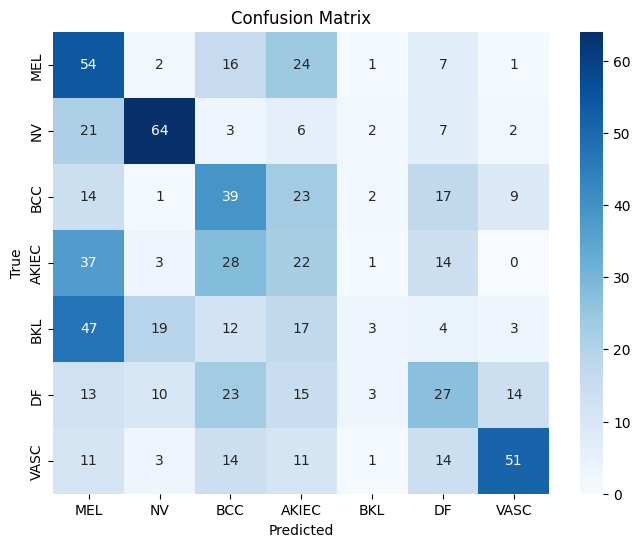

In [19]:
classes = ["MEL", "NV","BCC","AKIEC","BKL","DF","VASC"]

conf_matrix = confusion_matrix(Ytest_true, Ytest_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()